<a href="https://colab.research.google.com/github/bintangazhari/airqualityindexjkt/blob/main/time_series_lstm_bintang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a Time Series LSTM prediction by Bintang Azhari
This dataset is taken from Kaggle
https://www.kaggle.com/datasets/senadu34/air-quality-index-in-jakarta-2010-2021
In this project, I would like to predict the pm10 of the air quality

First, Let's try to download the dataset from kaggle

Reference I use:
https://ravi-chan.medium.com/how-to-download-any-data-set-from-kaggle-7e2adc152d7f

In [ ]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import opendatasets
from zipfile import ZipFile


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
from keras.layers import Dense, LSTM

import matplotlib.pyplot as plt

Download & Store the dataset

In [ ]:

# Create parent Folder for the project
dir_base = r'C:\Users\Admin\Documents\IDCamp\time-series-lstm'
os.mkdir(dir_base)

# Kaggle API token
token = r'C:\Users\Admin\Downloads\kaggle.json'

# Copy the token into the parent folder
shutil.copy(token, dir_base)

# change directory to parent folder
os.chdir(dir_base)

# download datasets, the output is a folder of dir_base + shoppersentiments
dataset_url = 'https://www.kaggle.com/datasets/senadu34/air-quality-index-in-jakarta-2010-2021'
opendatasets.download(dataset_url, dir_base)

# move the selected dataset into the parent folder
shutil.copy(os.path.join(dir_base,'air-quality-index-in-jakarta-2010-2021\ispu_dki1.csv'), dir_base)


'C:\\Users\\Admin\\Documents\\IDCamp\\time-series-lstm\\ispu_dki1.csv'

Clean the dataset. Choose the certain column as a feature to predict in this project.
In this project, i choose the pm10.
Then, fill the NaN with the average.
If NaN still occurs, remove the subset of the data.

In [ ]:
# read the file, select the necessary column, then check the blank data
df = pd.read_csv('ispu_dki1.csv')
df = df[['tanggal', 'pm10']]
df.isnull().sum()

# then replace the blank data with the rolling mean with 6 days window, then check again blank data
df['pm10'] = df['pm10'].fillna(df['pm10'].rolling(6,min_periods=1).mean())
df.isnull().sum()

# check the blank data
df[df['pm10'].isnull()]
# because the majority of blank data is in continous period, so i think i will remove the data
df.dropna(subset='pm10', inplace=True)

print(df['pm10'].max(),df['pm10'].min())

104.0 4.0


Plot the data to see the distribution accross the date

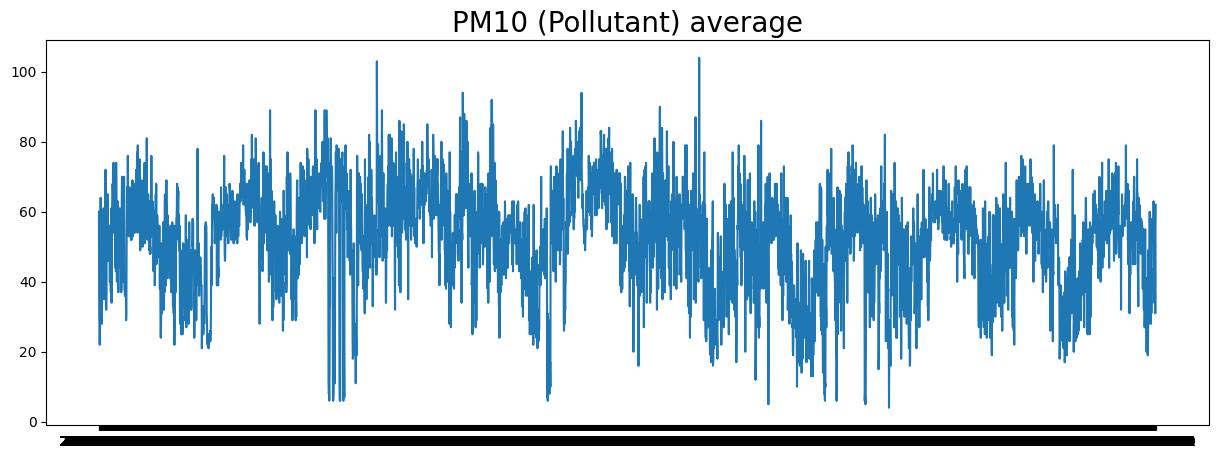

In [ ]:
# plot the data
dates = df['tanggal'].values
pm10  = df['pm10'].values


plt.figure(figsize=(15,5))
plt.plot(dates, pm10)
plt.title('PM10 (Pollutant) average',
          fontsize=20);

Because we target to have <10% MAE, we scale the pm10 first using min max scaler so the range is 0 - 1

In [ ]:
scaler = MinMaxScaler()
scaler.fit(pm10.reshape(-1,1))
df['pm10'] = scaler.transform(pm10.reshape(-1,1))
df

,tanggal,pm10
0,2010-01-01,0.56
1,2010-01-02,0.28
2,2010-01-03,0.23
3,2010-01-04,0.18
4,2010-01-05,0.21
...,...,...
4378,2021-12-27,0.48
4379,2021-12-28,0.47
4380,2021-12-29,0.27
4381,2021-12-30,0.51


Transform the data using the function provided by dicoding

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

Split the data as the requirement.
Because it is time seris, it can't be random.
We set the data_train as the 80% of older data and the rest is assigned as data_test

In [ ]:
data_train, data_test = train_test_split(df, test_size=0.2, shuffle=False, stratify=None)
dataset_train = windowed_dataset(data_train['pm10'], window_size=60, batch_size=100, shuffle_buffer=1000)
dataset_test = windowed_dataset(data_test['pm10'], window_size=60, batch_size=100, shuffle_buffer=1000)


Callback
to get 5 star, <10% mae must be achieved.
We try to achieve higher, <5%

In [ ]:
# create a callback function from inheritance of keras callback
class tf_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_mae') < 0.05 and logs.get('mae') < 0.05):
            self.model.stop_training = True

callbacks = tf_callback()

Design the model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=False),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])
history = model.fit(dataset_train,epochs=100, validation_data=dataset_test, callbacks = [callbacks])

Epoch 1/100
35/35 [==============================] - 19s 246ms/step - loss: 0.0484 - mae: 0.2447 - val_loss: 0.0084 - val_mae: 0.0978
Epoch 2/100
35/35 [==============================] - 7s 183ms/step - loss: 0.0100 - mae: 0.1102 - val_loss: 0.0064 - val_mae: 0.0869
Epoch 3/100
35/35 [==============================] - 7s 172ms/step - loss: 0.0087 - mae: 0.1011 - val_loss: 0.0061 - val_mae: 0.0846
Epoch 4/100
35/35 [==============================] - 6s 176ms/step - loss: 0.0086 - mae: 0.1010 - val_loss: 0.0050 - val_mae: 0.0788
Epoch 5/100
35/35 [==============================] - 7s 177ms/step - loss: 0.0078 - mae: 0.0941 - val_loss: 0.0052 - val_mae: 0.0786
Epoch 6/100
35/35 [==============================] - 7s 178ms/step - loss: 0.0077 - mae: 0.0931 - val_loss: 0.0048 - val_mae: 0.0762
Epoch 7/100
35/35 [==============================] - 6s 174ms/step - loss: 0.0076 - mae: 0.0929 - val_loss: 0.0056 - val_mae: 0.0821
Epoch 8/100
35/35 [==============================] - 7s 174ms/step -

Plot the loss function and the MAE

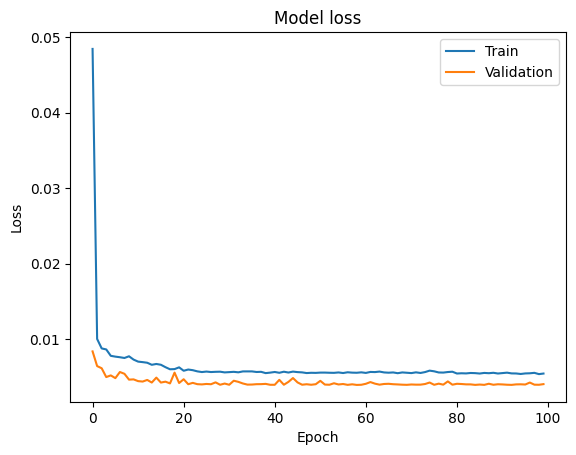

In [ ]:
# plot the result - plot the model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

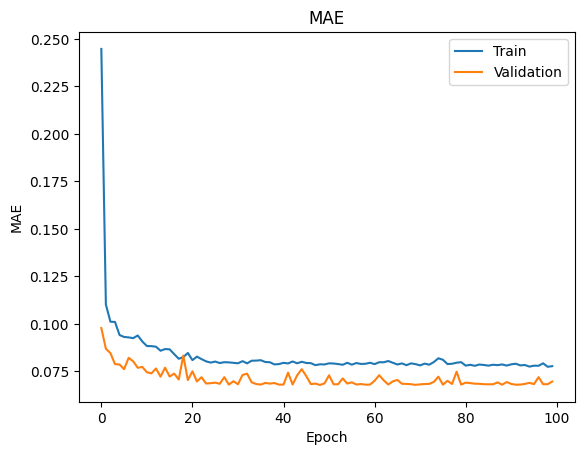

In [ ]:
# plot the model accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()